In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

Read the csv files, drop duplicate rows and visualise each csv file

In [66]:
# Get a list of all CSV files in the data folder
data_folder = 'data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
# Loop through the CSV files

dataframes = []
for idx, csv_file in enumerate(csv_files):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(data_folder, csv_file), sep=";")
        
        # Drop duplicate rows
        df = df.drop_duplicates()
        if idx == 0:
            df['wine_type'] = 0 # Red wine
        else:
            df['wine_type'] = 1 # White wine           

        dataframes.append(df)

def visualize_dfs(dataframes):
    for df in dataframes:
        # Visualize the data
        df.hist(figsize=(10, 10))
        plt.show()

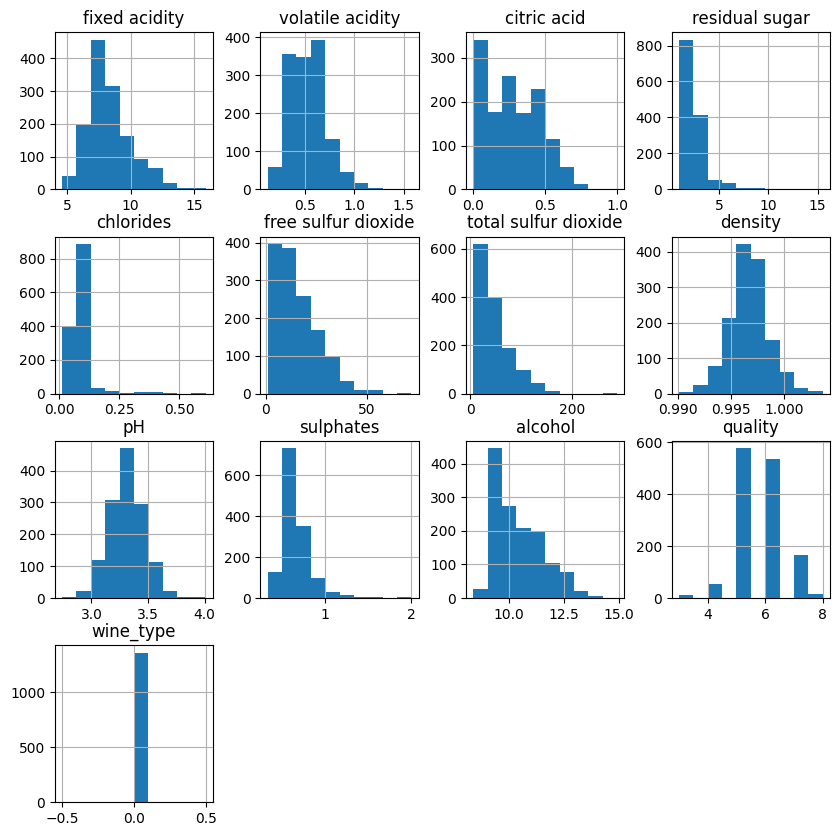

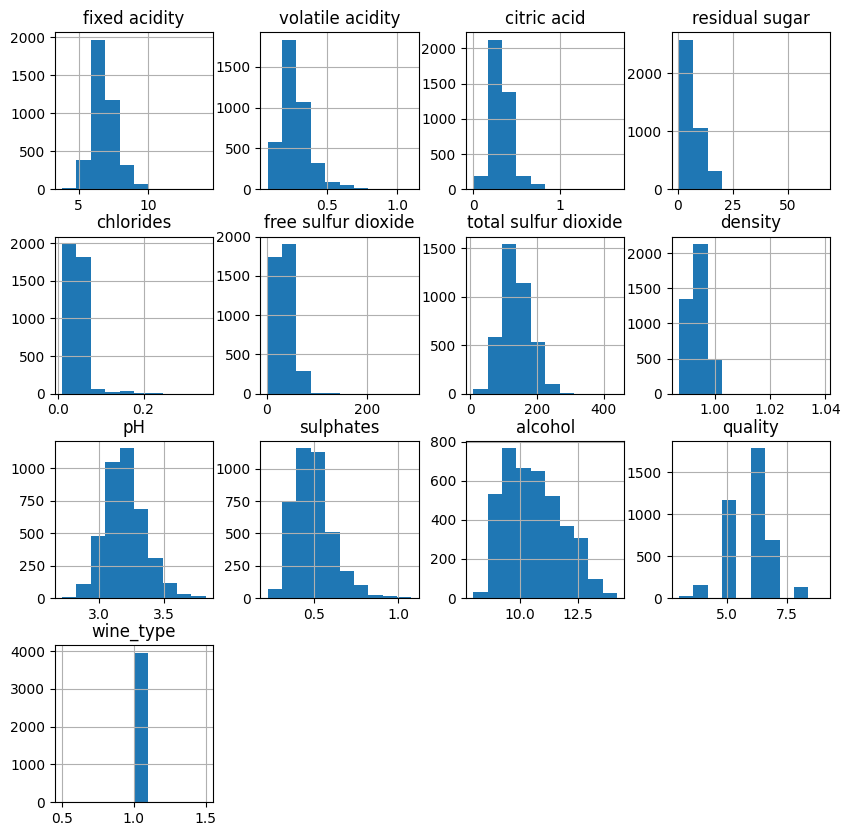

In [67]:
visualize_dfs(dataframes)

In [68]:
from collections import Counter

print(Counter(dataframes[0].quality))
print(Counter(dataframes[1].quality))

Counter({5: 577, 6: 535, 7: 167, 4: 53, 8: 17, 3: 10})
Counter({6: 1788, 5: 1175, 7: 689, 4: 153, 8: 131, 3: 20, 9: 5})


We see that there is not a good spread in the qualities. For both the red wine csv and white wine csv we notice that some qualities are less represented than others. To begin with, qualities <= 5 are less common, while higher qualities are more common. In the case of red wine we alse see that quality score 8 is uncommon. To solve this, we create a new quality rating system with scores 1-4 where some quality classes in the original data are merged together. What we will do is the following:

quality 3 + 4 --> quality 1
quality 5 --> quality 2
quality 6 --> quality 3
quality 7 + 8 --> quality 4

Lastly, we concatenate the two dataframes (red and white wine) and visualize the data. Although quality one is still not as common as the higher qualities, it is still better represented than the original quality 1.

In [69]:
for df in dataframes:
    df.loc[df.quality < 5, 'quality'] = 1
    df.loc[df.quality == 5, 'quality'] = 2
    df.loc[df.quality == 6, 'quality'] = 3
    df.loc[df.quality > 6, 'quality'] = 4

#concatenate the dataframes
dataframe_tot = pd.concat(dataframes)
dataframe_tot = dataframe_tot.drop_duplicates()


Counter({1: 3961, 0: 1359})
Counter({3: 2323, 2: 1752, 4: 1009, 1: 236})


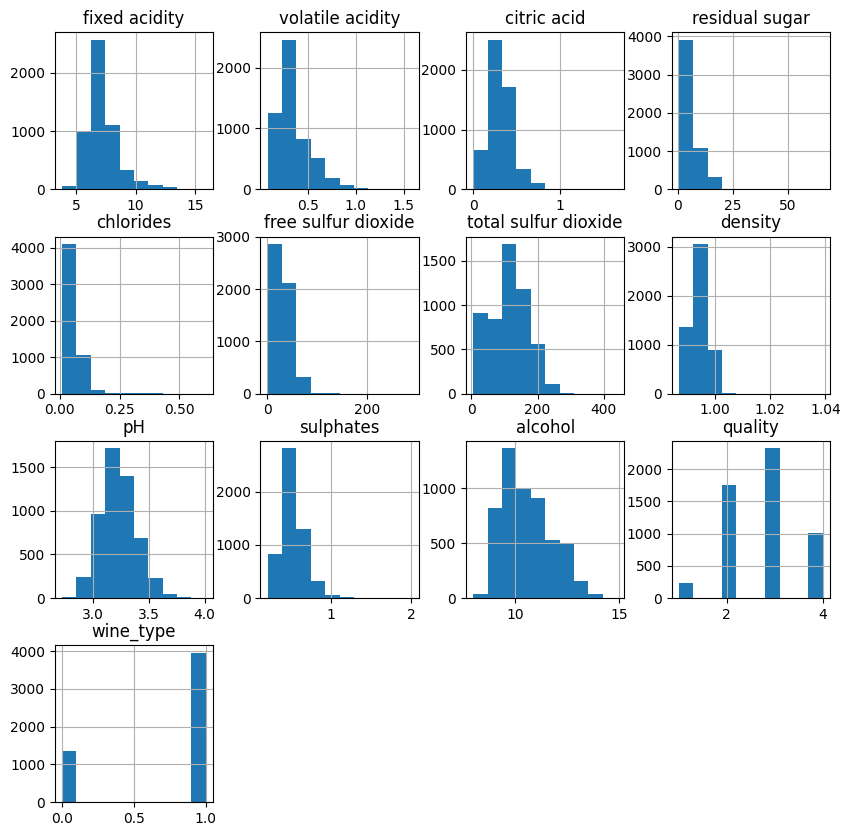

In [70]:
print(Counter(dataframe_tot.wine_type))
print(Counter(dataframe_tot.quality))
visualize_dfs([dataframe_tot])

Now, we will investigate which features have significance when we want to predict the wine quality. We also take notice in the fact that some features represent the same feature characteristic, so we will try to avoid using multiple versions of the same type of feature. 

# Red wine

In [71]:
def feature_importance(dataframe, title, threshold=0.015):
    X, y = dataframe.drop('quality', axis=1), dataframe['quality']
    y = pd.DataFrame(y, columns=['quality'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)
    clf = RandomForestClassifier(n_estimators=500)
    clf.fit(X_train, y_train)

    perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=10,  n_jobs=-1)

    indices = np.where(perm_importance.importances_mean >= threshold)[0]
    perm_importance = pd.DataFrame(data = perm_importance.importances_mean[indices], index=X.columns[indices], columns=['importance'])
    perm_importance.sort_values(by='importance', ascending=False, inplace=True)
    perm_importance.plot(kind='barh', figsize=(10, 10), title=title)
    plt.show()
    return perm_importance
        

/tmp/ipykernel_80217/231031061.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


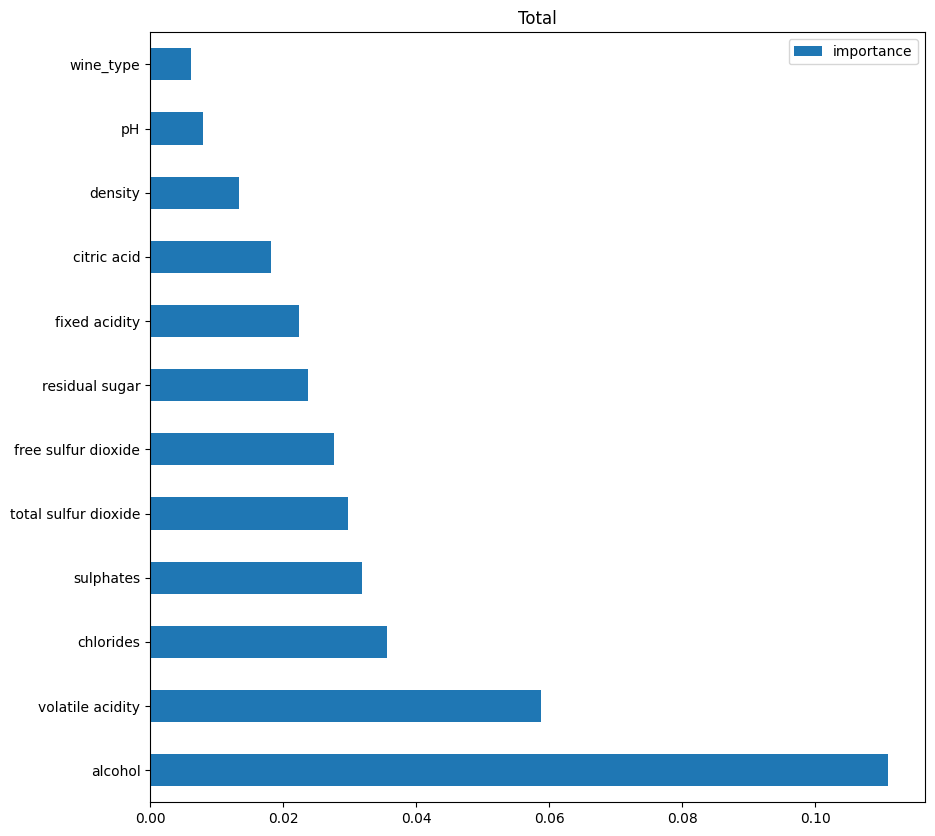

In [72]:
total_importance = feature_importance(dataframe_tot, 'Total', threshold=0.0)

In [78]:
print(total_importance[total_importance.importance > 0.03])

                  importance
alcohol             0.110996
volatile acidity    0.058741
chlorides           0.035620
sulphates           0.031861


Based on the threshold 0.02, we pick out the following common important features:

- alcohol
- volatile acidity
- sulphates
- chlorides

In [74]:
X, y = dataframes[0].drop('quality', axis=1), dataframes[0]['quality']
y = pd.DataFrame(y, columns=['quality'])

X = X[total_importance.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)

# random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest Classifier confusion matrix:')
print(classification_report(y_test, rfc_pred))
print('Random Forest Classifier accuracy:')
print(accuracy_score(y_test, rfc_pred))

# gradient boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100, random_state=10)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
print('Gradient Boosting Classifier confusion matrix:')
print(classification_report(y_test, gbc_pred))
print('Gradient Boosting Classifier accuracy:')
print(accuracy_score(y_test, gbc_pred))

# logistic regression
lr = LogisticRegression(random_state=10)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression confusion matrix:')
print(classification_report(y_test, lr_pred))
print('Logistic Regression accuracy:')
print(accuracy_score(y_test, lr_pred))

# support vector machine
svm = SVC(random_state=10)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print('Support Vector Machine confusion matrix:')
print(classification_report(y_test, svm_pred))
print('Support Vector Machine accuracy:')
print(accuracy_score(y_test, svm_pred))

# k-nearest neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('K-Nearest Neighbors confusion matrix:')
print(classification_report(y_test, knn_pred))
print('K-Nearest Neighbors accuracy:')
print(accuracy_score(y_test, knn_pred))




/tmp/ipykernel_80217/3171627433.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Random Forest Classifier confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.67      0.71      0.69        58
           3       0.54      0.59      0.57        54
           4       0.56      0.50      0.53        18

    accuracy                           0.60       136
   macro avg       0.44      0.45      0.45       136
weighted avg       0.58      0.60      0.59       136

Random Forest Classifier accuracy:
0.6029411764705882


/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Gradient Boosting Classifier confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.67      0.71      0.69        58
           3       0.51      0.54      0.52        54
           4       0.44      0.39      0.41        18

    accuracy                           0.57       136
   macro avg       0.40      0.41      0.41       136
weighted avg       0.55      0.57      0.56       136

Gradient Boosting Classifier accuracy:
0.5661764705882353
Logistic Regression confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.73      0.81      0.77        58
           3       0.59      0.76      0.67        54
           4       0.67      0.11      0.19        18

    accuracy                           0.66       136
   macro avg       0.50      0.42      0.41       136
weighted avg       0.64      0.66      0.6

/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

Best results were achieved with Logistic Regression, so the training algorithm will use this model architecture.